<a href="https://colab.research.google.com/github/trudramukerji14/Gaussianfield/blob/main/MNIST2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a rough implementation of the model used in ["Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions"](https://mlg.eng.cam.ac.uk/zoubin/papers/zgl.pdf) using Pytorch. This is still an ongoing work in process as of 10/30/22 more updated versions of this implementation will follow. 

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt




We partition our dataset $\mathcal{D}$ into training data (labeled) $\mathcal{D}_{1}$ data and test data (unlabeled data) $\mathcal{D}_{2}$. For the semi-supervised setting, we take $\mathcal{D}_{1}$ to consist of labeled data and $\mathcal{D}_{2}$ to consist of unlabeled data.

In [ ]:
#Loading the MNIST training and test data:

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#To ease computation we see if we can reduce the size of the training and test data set:

nb_selected_train_data = 600
nb_selected_test_data = 250
print(train_data.data.shape)
print(test_data.data.shape)
#
train_data.data = train_data.data[:nb_selected_train_data:,]
train_data.targets = train_data.targets[:nb_selected_train_data:,]
print(train_data.data.shape)
print(train_data.targets.shape)



test_data.data = test_data.data[:nb_selected_test_data:,]
test_data.targets = test_data.targets[:nb_selected_test_data:,]
print(test_data.data.shape)
print(test_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([600, 28, 28])
torch.Size([600])
torch.Size([250, 28, 28])
torch.Size([250])


In [ ]:
#To make this a binary classification problem, we seperate 0's and 1's
train_subset_indices = ((train_data.targets == 0) + (train_data.targets == 1)).nonzero().view(-1)
test_subset_indices = ((test_data.targets == 0) + (test_data.targets == 1)).nonzero().view(-1)

train_data.data = train_data.data[train_subset_indices]
train_data.targets = train_data.targets[train_subset_indices]
test_data.data = test_data.data[test_subset_indices]
test_data.targets = test_data.targets[test_subset_indices]



Given $N$ datapoints in $\mathbb{R}^{m}$, we define the weight matrix as $W$ whose $ij$ entries are given by 
$$w_{ij} = \exp\bigg(\sum^{m}_{d=1} (x_{id}-x_{jd})^{2}/\sigma^{2}_{d}\bigg)$$
So a naive approach would be to perform this computation that takes $O(m)$ time $N^{2}$ times this gives a time of $O(mN^{2})$ to compute the matrix $W$. We then can set $\sigma$ to be the variable to be optimized with pytorch . $\sigma$ is the hyperparameter to be tuned for this model with regards to the entropy defined below.

In [ ]:
#Takes sigma as an input

def wtrain(i,j,sigma):
   sigma2 = torch.square(sigma)
   s = train_data.data[i]
   t = train_data.data[j]
   s = torch.flatten(s)
   t = torch.flatten(t)
   d = (s-t)/1000
   d = d/sigma2
   d = (torch.norm(d))**2
   d = torch.exp(-d)
   return d

def wtraintest(i,j, sigma):
   sigma2 = torch.square(sigma)
   s = train_data.data[i]
   t = test_data.data[j]
   s = torch.flatten(s)
   t = torch.flatten(t)
   d = (s-t)/1000
   d = d/sigma2
   d = (torch.norm(d))**2
   d = torch.exp(-d)
   return d

def wtest(i,j,sigma):
   sigma2 = torch.square(sigma)
   s = test_data.data[i]
   t = test_data.data[j]
   s = torch.flatten(s)
   t = torch.flatten(t)
   d = (s-t)/1000
   d = d/sigma2
   d = (torch.norm(d))**2
   d = torch.exp(-d)
   return d



The harmonic solution $\Delta{f}=0$ subject to the given boundary conditions $f(i) = y_{i}$ for $i \in D_{1}$ is given by 
    \begin{equation} \tag{5}
            f_{u} = (D_{uu} -W_{uu})^{-1}W_{ul}f_{l}
    \end{equation}
which is what's given by the function `groundstate(sigma)` below


In [ ]:
xtrain = (np.array(list(train_subset_indices)))
Ntrain = xtrain.size
xtest = (np.array(list(test_subset_indices)))
Ntest = xtest.size
xtrain = np.arange(Ntrain)
xtest = np.arange(Ntest)



def Wuu(sigma):
  A = torch.zeros((Ntest,Ntest))
  for i in xtest:
    for j in xtest:
     A[i,j] = wtest(i,j,sigma)
  return A

def  Wlu(sigma):
#Define Wlu:
  A = torch.zeros((Ntrain,Ntest))
  for i in xtrain:
    for j in xtest:
      A[i,j] = wtraintest(i,j,sigma)
  return A



def Wll(sigma):
#Define Wll:
  A = torch.zeros((Ntrain, Ntrain))
  for i in xtrain:
    for j in xtrain:
      A[i,j] = wtrain(i,j,sigma)
  return A

M = 28*28
sigma = np.ones(M)
sigma = Variable(torch.tensor(sigma), requires_grad=True)


#Define W:
def W(sigma):
  A = Wll(sigma)
  B = Wlu(sigma)
  C = torch.t(B)
  D = Wuu(sigma)
  Wl = torch.cat([A,B], dim = 1 ) #Wl = np.block([Wll, Wlu])
  Wu = torch.cat([C,D], dim = 1 ) #Wu = np.block([Wul, Wuu])
  W = torch.cat([Wl, Wu], dim = 0) #W = np.block([[Wl],[Wu]])
  return W

def Duu(sigma):
  A = W(sigma)
  diagonal = torch.sum(A, axis = 1)
  diagonalu = diagonal[-Ntest:]
  A = torch.diag(diagonalu)
  return A

def operator(sigma):
  A = Duu(sigma)
  B = Wuu(sigma)
  A = A-B
  A = torch.linalg.inv(A)
  return A




def groundstate(sigma):
  train_data.targets = train_data.targets.type(torch.FloatTensor)
  B = Wlu(sigma)
  C = torch.t(B)
  fl = np.array(list(train_data.targets))
  fl = torch.from_numpy(fl)
  A = operator(sigma)
  fu = torch.matmul(C, fl)
  fu = torch.matmul(A,fu)
  return fu
















In [ ]:
#Need to check this

Xuu = Wuu(sigma)
#print(Wuu.shape)
Xlu = Wlu(sigma)
print(Xlu.shape)
Xul = torch.t(Xlu)
print(Xul.shape)
Xll = Wll(sigma)
print(Xll.shape)
X = W(sigma)
X = Duu(sigma)
X = operator(sigma)
xu = groundstate(sigma)



torch.Size([116, 45])
torch.Size([45, 116])
torch.Size([116, 116])


The cost function used is the entropy:
\begin{equation}
    H(f) =  \frac{1}{u}\sum H_{i}(f_{u}(i))
\end{equation}
where 
\begin{equation}
 H_{i}(f_{u}(i))=-f_{u}(i)\log(f_{u}(i)) - (1-f_{u}(i))\log(1-f_{u}(i))   
\end{equation}
and $u$ is the number of test vertices

In [ ]:
def crossentropy(f,i):
  x = -1*(f[i]*torch.log(f[i])+(1-f[i])*(torch.log(1-f[i])))
  return x


def averagelabelentropy(sigma):
  f = groundstate(sigma)
  N = len(f)
  x = 0
  for i in np.arange(len(f)):
    x = x + crossentropy(f,i)
    x = x/N
  return x

print(averagelabelentropy(sigma))


tensor(0.0084, grad_fn=<DivBackward0>)


In [ ]:
# set up the optimizer
opt = torch.optim.Adam([sigma], lr=0.01)

#number of steps in the optimization routine
steps =  10

# the final stage of optimization isn't always the best, so we keep track of
# the best parameters along the way
best_cost = averagelabelentropy(sigma)


print("Cost after 0 steps is {:.4f}".format(averagelabelentropy(sigma)))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = averagelabelentropy(sigma)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost 
        best_cost = loss
        best_params = sigma

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))






Cost after 0 steps is 0.0084
Cost after 10 steps is 0.0028


In [ ]:
best_sigma = best_params
xu = groundstate(best_sigma)
print(xu)



tensor([0.9938, 0.9104, 0.9926, 0.9441, 0.9156, 0.9905, 0.9035, 0.8261, 0.9934,
        0.9927, 0.9928, 0.9914, 0.9931, 0.9926, 0.9294, 0.9934, 0.9529, 0.8776,
        0.9931, 0.9933, 0.9918, 0.9911], grad_fn=<MvBackward0>)


In [ ]:
#How do I count the 0's in the training data?

#train_subset_indices = ((train_data.targets == 0) + (train_data.targets == 1)).nonzero().view(-1)

train_zero_indices = (train_data.targets == 0).nonzero().view(-1)
print(train_zero_indices)
print(train_zero_indices.shape)
Nzeros = np.array(list(train_zero_indices.shape)).sum()
print(Nzeros)

train_one_indices = (train_data.targets == 1).nonzero().view(-1)
print(train_one_indices)
print(train_one_indices.shape)
Nones = np.array(list(train_one_indices.shape)).sum()
print(Nones)

q = Nones/(Nzeros + Nones)




#print(train_data.targets.shape)
#print(test_data.data.shape)
#print(test_data.targets.shape)
#N = ((train_data.targets.shape)+ test_data.targets.shape)
#print(N)
#N = (np.array(list(N))).sum()
#print(N)


tensor([  0,   5,   8,   9,  11,  12,  14,  16,  17,  20,  23,  24,  25,  30,
         33,  34,  35,  36,  41,  42,  46,  50,  52,  53,  55,  57,  59,  60,
         61,  63,  65,  69,  71,  72,  73,  77,  78,  84,  90,  94,  95,  96,
         97, 101, 102, 105, 106, 107, 110, 113])
torch.Size([50])
50
tensor([  1,   2,   3,   4,   6,   7,  10,  13,  15,  18,  19,  21,  22,  26,
         27,  28,  29,  31,  32,  37,  38,  39,  40,  43,  44,  45,  47,  48,
         49,  51,  54,  56,  58,  62,  64,  66,  67,  68,  70,  74,  75,  76,
         79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  91,  92,  93,  98,
         99, 100, 103, 104, 108, 109, 111, 112, 114, 115])
torch.Size([66])
66


Let's assume that the proportion of ones to zeros in the training data is represented by $q$ and the proportion of zeros to ones in the training data is represented by $1-q$. We then classify a vertex $i$ or datapoint as a one
 as  if:   $$q \frac{f_{u}(i)}{\sum_{i} f_{u}(i)} > (1-q)\frac{1-f_{u}(i)}{\sum_{i}(1- f_{u}(i))}$$
We define a function that applies this to our harmonic function $f_{u}$


In [ ]:


def classify(x):
  N = len(x)
  y = np.zeros(N)
  sum = x.sum()
  for i in np.arange(N):
     LHS = q*(x[i]/sum) 
     RHS = (1-q)*((1-x[i])/(N-sum))
     if LHS > RHS:
       y[i] = 1
     else:
       y[i] = 0
  return y







The following codebox is an example of how the classifier works

tensor(19.7123, grad_fn=<SumBackward0>)
tensor(0.0281, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>)


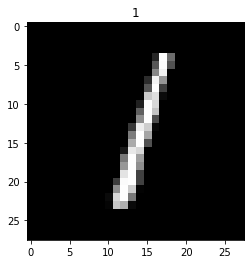

In [ ]:
x = xu
N = len(x)
i = 0
sum = x.sum()
print(sum)
LHS = q*(x[i]/sum)
RHS = (1-q)*((1-x[i])/(N-sum))
print(LHS,RHS)

plt.imshow(test_data.data[i], cmap='gray')
plt.title('%i' % test_data.targets[i])
plt.show()


In [ ]:
xu[0]
xu = groundstate(sigma)
print(xu)
print(q)
classified = classify(xu)
print(classified)

tensor([0.9663, 0.7736, 0.9648, 0.8104, 0.7635, 0.9559, 0.7779, 0.6916, 0.9667,
        0.9616, 0.9652, 0.9640, 0.9636, 0.9644, 0.8175, 0.9666, 0.8439, 0.6964,
        0.9684, 0.9692, 0.9694, 0.9517, 0.7262, 0.9582, 0.8623, 0.9651, 0.7043,
        0.9740, 0.9710, 0.9618, 0.7266, 0.9606, 0.8251, 0.9604, 0.9636, 0.9742,
        0.9720, 0.8858, 0.7542, 0.9570, 0.9747, 0.9536, 0.8158, 0.6872, 0.9646],
       grad_fn=<MvBackward0>)
0.5689655172413793
[1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.]


Since we actually have labels, we can test the accuracy of this approach. Which brings up the function defined in the codebox below


In [ ]:
def accuracy(sigma):
  x = groundstate(sigma)
  y = classify(x)
  t = test_data.targets
  t = torch.Tensor.numpy(t)
  z = y-t
  z = z.sum()/len(z)
  z = 1-z
  return z
  


In [ ]:
print(test_data.targets)
t = test_data.targets
t = torch.Tensor.numpy(t)
classified-t


tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])